<a href="https://colab.research.google.com/github/wqiu96/summer_project/blob/master/src/multiprocessing_GPU_try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import time
start_time = time.time()
import matplotlib.pyplot as plt
import multiprocessing

In [0]:
class pde:
  def __init__(self,NUM,MAX_ITER,LIM,q_table,s_val):
    #pde config
    
    self.LIM_ = LIM
    self.LIM = np.array([0,1])
    
    self.MAX_ITER = MAX_ITER
    
    self.name = 'HJB 1d'
    self.NUM = NUM
    self.h = 1./self.NUM #mesh size in state space
    self.lambda_ = 0. #discount rate
    self.sigma = 1. #diffusion coefficient
    self.drift = lambda x,a: a #drift coefficient function
      
    self.s_space = np.arange(self.LIM[0], self.LIM[1]+self.h, self.h) #state space

    self.a_space = np.arange(2*self.LIM[0], 2*self.LIM[1] + self.h, self.h) #action space

    self.del_ind_space = np.array([-1,1]) #space of delta (1-step) index: -1 means left, 1 means right move

    self.term_ind_space = np.array([0, self.s_space.size-1]) #space of terminal state indice

    #q-table and state value initialization

    self.s_val = s_val
    self.q_table = q_table
  
    self.run_cost = lambda x, a: (a**2+1)/2.

    C1 = 1; C2 = 1
    self.term_cost = lambda x: - np.log(C1*np.exp(x) + C2*np.exp(-x))
    
    #pde exact solution if available
    self.exact_sol = self.term_cost

In [0]:
def mdp_space_config(self):  #num of meshes in one unit state space
  
  index = ((self.LIM_ - self.LIM[0])/self.h).astype(int)
  
  #s_val and q-table terminal setup
  for i in range(len(index)):
    if index[i] in self.term_ind_space:
      self.s_val[index[i]] = self.term_cost(self.s_space[index[i]])
      for j in range(self.a_space.size):
        self.q_table[index[i],j] = self.term_cost(self.s_space[index[i]])
    else:
      if index[i] > index[0]:
        for k in range(index[i],self.s_space.size):
          self.s_val[k] = 2
          for j in range(self.a_space.size):
            self.q_table[k,j] = 2
      else:
        for k in range(0,index[0]+1):
          self.s_val[k] = 2
          for j in range(self.a_space.size):
            self.q_table[k,j] = 2
  
  
pde.mdp_space_config = mdp_space_config

In [0]:
#transition probability
#output is probability (np array) on del_ind_space 
#central fdm

def mdp_trans_prob_central(self,x,a):
  tp = np.zeros(self.del_ind_space.shape)
  
  b_ = self.drift(x,a)
  tp[0] = (-b_*self.h + self.sigma**2)/(2*self.sigma**2)
  tp[1] = (b_*self.h + self.sigma**2)/(2*self.sigma**2)
  
  #correction on prob
  if tp[1]<0:
    tp = tp - tp[1]
    tp = tp/tp.sum()
    print('>>>>corrected probability due to negativity')

  return tp  

pde.mdp_trans_prob_central = mdp_trans_prob_central

In [0]:
def value_iter(self):
  
  if (self.q_table ==  np.zeros(self.q_table.shape)).all():
    self.mdp_space_config()
  index = ((self.LIM_ - self.LIM[0])/self.h).astype(int)
  n_iter = 0 #iteration counter

  while n_iter < self.MAX_ITER:
    pre_s_val = self.s_val.copy()

    for i in range(index[0]+1, index[1]):
      for k in range(self.a_space.size):
        x_ = self.s_space[i]
        a_ = self.a_space[k]
        tp_ = self.mdp_trans_prob_central(x_, a_)
        
        run_cost_ = self.run_cost(x_,a_)*self.h**2/self.sigma**2
        Lambda_ = 1 + self.lambda_* self.h**2/ self.sigma**2

        self.q_table[i,k] = (run_cost_ + 
                             tp_[0]*self.s_val[i-1] + 
                             tp_[1]*self.s_val[i+1])/Lambda_

      self.s_val[i] = np.min(self.q_table[i]) #sync q_table with s_val
    #err_ = np.max(np.abs(pre_s_val - self.s_val))

    n_iter += 1

  return self.q_table
     
      
pde.value_iter = value_iter 

In [0]:
def func(NUM,MAX_ITER,args, q_table ,s_val):
  pde1 = pde(NUM = NUM,MAX_ITER = MAX_ITER,LIM = args, q_table =  q_table, s_val = s_val)
  return pde1.value_iter()

>>>max norm of error is 0.0036462698378354474
elapsed time is 3.603656 seconds


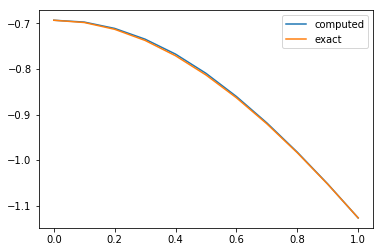

In [49]:
#cores = multiprocessing.cpu_count() cores = 2 in notebook

s_val = np.zeros(11)
q_table = np.zeros([11, 21])
err_ = 1. #error init
s_val = np.zeros(11)
while err_ > 0.001:
  pre_s_val = s_val.copy()
  results = []
  pool = multiprocessing.Pool(processes=2)
  args = [np.array([.0,0.6]),np.array([0.4,1])]
  for i in range(2):
    results.append(pool.apply_async(func, (10 , 10, args[i],q_table,pre_s_val,)))
  pool.close()
  pool.join()
  q_table = np.minimum(results[0].get(),results[1].get())
  for i in range(q_table.shape[0]):
    s_val[i] = np.min(q_table[i])
  err_ = np.max(np.abs(pre_s_val - s_val))
  
C1 = 1
C2 = 1
exact_val_f = lambda x: - np.log(C1*np.exp(x) + C2*np.exp(-x))
exact_val = exact_val_f(np.arange(0, 1.1, 0.1))
plt.plot(np.arange(0, 1.1, 0.1), s_val, label = 'computed')
plt.plot(np.arange(0, 1.1, 0.1), exact_val, label = 'exact')
plt.legend()

end_time = time.time()

print('>>>max norm of error is ' + str(np.max(np.abs(s_val-exact_val))))
print('elapsed time is %f seconds' %(end_time - start_time))